##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text generation with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate text using a character-based RNN. We will work with a dataset of Shakespeare's writing from Andrej Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Given a sequence of characters from this data ("Shakespear"), train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

Note: Enable GPU acceleration to execute this notebook faster. In Colab: *Runtime > Change runtime type > Hardware acclerator > GPU*. If running locally make sure TensorFlow version >= 1.11.

This tutorial includes runnable code implemented using [tf.keras](https://www.tensorflow.org/programmers_guide/keras) and [eager execution](https://www.tensorflow.org/programmers_guide/eager). The following is sample output when the model in this tutorial trained for 30 epochs, and started with the string "Q":

<pre>
QUEENE:
I had thought thou hadst a Roman; for the oracle,
Thus by All bids the man against the word,
Which are so weak of care, by old care done;
Your children were in your holy love,
And the precipitation through the bleeding throne.

BISHOP OF ELY:
Marry, and will, my lord, to weep in such a one were prettiest;
Yet now I was adopted heir
Of the world's lamentable day,
To watch the next way with his father with his face?

ESCALUS:
The cause why then we are all resolved more sons.

VOLUMNIA:
O, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, it is no sin it should be dead,
And love and pale as any will to that word.

QUEEN ELIZABETH:
But how long have I heard the soul for this world,
And show his hands of life be proved to stand.

PETRUCHIO:
I say he look'd on, if I must be content
To stay him from the fatal of our country's bliss.
His lordship pluck'd from this sentence then for prey,
And then let us twain, being the moon,
were she such a case as fills m
</pre>

While some of the sentences are grammatical, most do not make sense. The model has not learned the meaning of words, but consider:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text.

* The structure of the output resembles a play—blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* As demonstrated below, the model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.

## Setup

### Import TensorFlow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import os
import time

TensorFlow 2.x selected.


### Download the Shakespeare dataset

Change the following line to run this code on your own data.

In [0]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

### Read the data

First, look in the text:

In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [5]:
# Take a look at the first 250 characters in text
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [6]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

65 unique characters


## Process the text

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping characters to numbers, and another for numbers to characters.

In [0]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

Now we have an integer representation for each character. Notice that we mapped the character as indexes from 0 to `len(unique)`.

In [8]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [9]:
# Show how the first 13 characters from the text are mapped to integers
print('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'First Citizen' ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


### The prediction task

Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?


### Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [10]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

F
i
r
s
t


The `batch` method lets us easily convert these individual characters to sequences of the desired size.

In [11]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For each sequence, duplicate and shift it to form the input and target text by using the `map` method to apply a simple function to each batch:

In [0]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset_org = sequences.map(split_input_target)

Print the first examples input and target values:

In [13]:
for input_example, target_example in  dataset_org.take(1):
    print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the `RNN` considers the previous step context in addition to the current input character.

In [14]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 18 ('F')
  expected output: 47 ('i')
Step    1
  input: 47 ('i')
  expected output: 56 ('r')
Step    2
  input: 56 ('r')
  expected output: 57 ('s')
Step    3
  input: 57 ('s')
  expected output: 58 ('t')
Step    4
  input: 58 ('t')
  expected output: 1 (' ')


### Create training batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [15]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset_org.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## Build The Model

Use `tf.keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (You can also use a LSTM layer here.)
* `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs.

In [0]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [0]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![A drawing of the data passing through the model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/text_generation_training.png?raw=1)

## Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [19]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is `100` but the model can be run on inputs of any length:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Note: It is important to _sample_ from this distribution as taking the _argmax_ of the distribution can easily get the model stuck in a loop.

Try it for the first example in the batch:

In [0]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [22]:
sampled_indices

array([29, 59,  5, 39,  2, 29, 33, 39,  4,  8,  5, 59, 31, 59, 14, 35,  9,
       63, 49,  7,  1, 51,  7,  1, 51, 30, 59, 28, 26, 58, 58, 26,  4, 41,
        5, 11, 13, 25, 18,  5, 46, 42, 52, 32, 62,  0, 41, 45, 47, 35, 12,
       61, 10, 51, 55, 11, 25, 45, 10, 58,  1, 59, 18, 19, 25,  6, 18, 24,
        7, 56,  6, 23, 22, 45, 25, 57, 44, 37, 58, 58, 24, 53, 18, 43, 52,
       18, 47, 30, 58, 12, 30, 49,  9, 55,  1,  3, 25, 48,  8, 15])

Decode these to see the text predicted by this untrained model:

In [23]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 ' eyes,\nBy her high forehead and her scarlet lip,\nBy her fine foot, straight leg and quivering thigh\n'

Next Char Predictions: 
 "Qu'a!QUa&.'uSuBW3yk- m- mRuPNttN&c';AMF'hdnTx\ncgiW?w:mq;Mg:t uFGM,FL-r,KJgMsfYttLoFenFiRt?Rk3q $Mj.C"


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because our model returns logits, we need to set the `from_logits` flag.


In [24]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.1732593


Configure the training procedure using the `tf.keras.Model.compile` method. We'll use `tf.keras.optimizers.Adam` with default arguments and the loss function.

In [0]:
model.compile(optimizer='adam', loss=loss)

### Configure checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

To keep training time reasonable, use 10 epochs to train the model. In Colab, set the runtime to GPU for faster training.

In [0]:
EPOCHS=10

In [28]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 10s 60ms/step - loss: 2.6804
Epoch 2/10
172/172 [==============================] - 9s 51ms/step - loss: 1.9713
Epoch 3/10
172/172 [==============================] - 9s 52ms/step - loss: 1.7040
Epoch 4/10
172/172 [==============================] - 9s 51ms/step - loss: 1.5526
Epoch 5/10
172/172 [==============================] - 9s 50ms/step - loss: 1.4638
Epoch 6/10
172/172 [==============================] - 9s 50ms/step - loss: 1.4025
Epoch 7/10
172/172 [==============================] - 9s 50ms/step - loss: 1.3557
Epoch 8/10
172/172 [==============================] - 9s 50ms/step - loss: 1.3179
Epoch 9/10
172/172 [==============================] - 9s 50ms/step - loss: 1.2828
Epoch 10/10
172/172 [==============================] - 9s 50ms/step - loss: 1.2507


Text(0.5, 0, 'epoch')

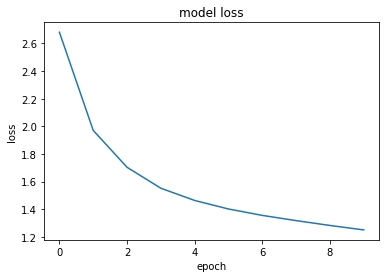

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.


In [30]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_10'

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

* It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

* Get the prediction distribution of the next character using the start string and the RNN state.

* Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

* The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one word. After predicting the next word, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted words.


![To generate text the model's output is fed back to the input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/text_generation_sampling.png?raw=1)

Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [0]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

The easiest thing you can do to improve the results it to train it for longer (try `EPOCHS=30`).

You can also experiment with a different start string, or try adding another RNN layer to improve the model's accuracy, or adjusting the temperature parameter to generate more or less random predictions.

## Performance Enhancements


### Problem (1b): Epochs = 50

In [0]:
model_50 = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [35]:
model_50.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, None, 256)           16640     
_________________________________________________________________
gru_2 (GRU)                  (64, None, 1024)          3938304   
_________________________________________________________________
dense_2 (Dense)              (64, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_50.compile(optimizer='adam', loss = loss)

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_50'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [38]:
EPOCHS_50=50
history_50 = model_50.fit(dataset, epochs=EPOCHS_50, callbacks=[checkpoint_callback])

Epoch 1/50
172/172 [==============================] - 10s 57ms/step - loss: 2.6646
Epoch 2/50
172/172 [==============================] - 9s 50ms/step - loss: 1.9590
Epoch 3/50
172/172 [==============================] - 9s 50ms/step - loss: 1.6887
Epoch 4/50
172/172 [==============================] - 9s 50ms/step - loss: 1.5404
Epoch 5/50
172/172 [==============================] - 8s 49ms/step - loss: 1.4544
Epoch 6/50
172/172 [==============================] - 8s 49ms/step - loss: 1.3939
Epoch 7/50
172/172 [==============================] - 9s 50ms/step - loss: 1.3492
Epoch 8/50
172/172 [==============================] - 8s 49ms/step - loss: 1.3115
Epoch 9/50
172/172 [==============================] - 9s 50ms/step - loss: 1.2772
Epoch 10/50
172/172 [==============================] - 9s 50ms/step - loss: 1.2426
Epoch 11/50
172/172 [==============================] - 9s 50ms/step - loss: 1.2129
Epoch 12/50
172/172 [==============================] - 9s 49ms/step - loss: 1.1804
Epoch 13/50


Text(0.5, 0, 'epoch')

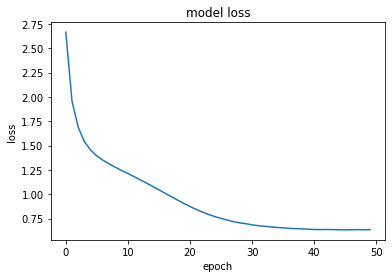

In [39]:
import matplotlib.pyplot as plt
plt.plot(history_50.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [40]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints_50/ckpt_50'

In [0]:
model_50 = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model_50.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_50.build(tf.TensorShape([1, None]))

In [42]:
model_50.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_3 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_3 (Dense)              (1, None, 65)             66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


#### Model_50 Analysis:

- We can see from the epoch Vs. loss graphs of both the models (model with epoch 10 and model_10 with epoch 50) that by increasing the number of epochs, we have greatly reduced loss from 1.2 to 0.6328.
- The graph shows consistency from iterations 42 to 50 which would be the ideal number of epochs to get a model with lowest loss.
- Low loss implies the model performance has improved to predict characters more accurately.

### Problem (1c): Tune hyper-parameters: batch_size = 25

In [43]:
batch_size_hyp = 25
model_hyp = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=batch_size_hyp)
BUFFER_SIZE = 10000
dataset_hyp = dataset_org.shuffle(batch_size_hyp).batch(batch_size_hyp, drop_remainder=True)
dataset_hyp

<BatchDataset shapes: ((25, 100), (25, 100)), types: (tf.int64, tf.int64)>

In [44]:
model_hyp.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (25, None, 256)           16640     
_________________________________________________________________
gru_4 (GRU)                  (25, None, 1024)          3938304   
_________________________________________________________________
dense_4 (Dense)              (25, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_hyp.compile(optimizer='adam', loss = loss)

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_hyp'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [47]:
EPOCHS_hyp=10
history_hyp = model_hyp.fit(dataset_hyp, epochs=EPOCHS_hyp, callbacks=[checkpoint_callback])

Epoch 1/10
441/441 [==============================] - 16s 37ms/step - loss: 2.2565
Epoch 2/10
441/441 [==============================] - 14s 32ms/step - loss: 1.6906
Epoch 3/10
441/441 [==============================] - 14s 32ms/step - loss: 1.5014
Epoch 4/10
441/441 [==============================] - 14s 32ms/step - loss: 1.4040
Epoch 5/10
441/441 [==============================] - 14s 32ms/step - loss: 1.3382
Epoch 6/10
441/441 [==============================] - 14s 32ms/step - loss: 1.2829
Epoch 7/10
441/441 [==============================] - 14s 32ms/step - loss: 1.2287
Epoch 8/10
441/441 [==============================] - 14s 32ms/step - loss: 1.1755
Epoch 9/10
441/441 [==============================] - 14s 32ms/step - loss: 1.1234
Epoch 10/10
441/441 [==============================] - 14s 32ms/step - loss: 1.0782


Text(0.5, 0, 'epoch')

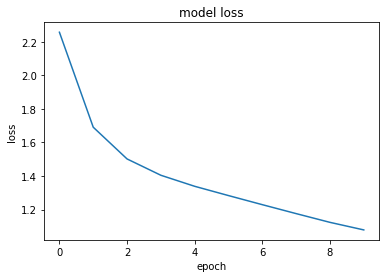

In [48]:
plt.plot(history_hyp.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [49]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints_hyp/ckpt_10'

In [0]:
model_hyp = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model_hyp.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_hyp.build(tf.TensorShape([1, None]))

#### Model_hyp Analysis

- The batch_size is a hyperparameter which defines the number of samples to work through before updating the internal model parameters.
- We can see that the loss for model with 10 epoch and 64 batch_size is greater than model_hyp with 10 epoch and batch_size 25.
- Lower loss implies improved model efficiency

### Problem 2: Evaluation

- The outputs for all the models by taking the start string as "ROMEO" is generated.
- The Bleu score for all the outputs is calculated.
- The reference sentences are taken from the dataset. A list of reference sentences is formed by taking the start string "ROMEO" and 1000 characters following "R"


In [0]:
text_model = generate_text(model, start_string=u"ROMEO: ")
text_model_50 = generate_text(model_50, start_string=u"ROMEO: ")
text_model_hyp = generate_text(model_hyp, start_string=u"ROMEO: ")

In [57]:
print(text_model)

ROMEO: I am, but shall be so?

MIRANDA:
O heavy sir; but thou dost follow your heart that
Both with thy bir upon their husband;
He hath spepted wied arm, dubble into his praise
In too fowl'd in the field by the Duke of Richard, Rosaline shall sit id in my plage? Yet you my daughter to your
secure wars with that, I told you and play.

VERDINA:
What's of impwer.

MENENIUS:
While here, than heel him so good a right.
Prepare your haste which he leads here!

ESCALUS:
Love the wild of our that with his unformy.

LUCHID have made but voison.

GLOUCESTER:
3 KING HENRY BELIA:
Heavens! is quarrel's reward by towards!
And therefore, journe your hand anon
The evon on his lady made drunk
The custom of the city?
What sacce'd me to, raises her from hell,
And, let the senseless vastions more than 'twas blood
And all their souls do here in Any colour's like
He was breath, and take itsuide of seasy.
Th the dearest hand that speach with others
And they suffer to you: buty by the be moner?
Ifallows that n

In [58]:
print(text_model_50)

ROMEO: I am not firm,
But stop insultial forbid give noim!

QUEEN MARGARET:
Why, then the English crown is grief!

DEONTES:
No; to the Capitoly will be now,
One word of justice, you're pleased with thee!

LADY GREY:
The fire and cockeretch his head.
Go, till, a wife! Can he that safeguard like an und;
But, cousin, for they are at handerish profanation home with ker is done,
to may so body from him, and I do not know,
Which made me ear it in the mind. Fear thou dost const them of our mischance: the kin respecting
cannot black my countenances from the birth,
Claudio down, thou hadst any of imprisonment.

CAPULET:
Sogety their office greater.

AUTOLYCUS:
If I your voices?

First Citizen:
First, madam,
This is the breath of Edward's death dirtced him at the salt, you wounded senses of their death,
The one infection of part they must make
you aurt'st an opposite the measure of these dew strike at an
Anvilis, greater drink as from alteraties
Who mights some chaim in dust bare praise their st

In [59]:
print(text_model_hyp)

ROMEO: none but time?

PROSPERO:
Good father, sir?
Py Prievial islands! no more
Some proudst behind, Ory sickey at the signal of His
ago, grew-lasts, after of this new my want,
Sitting to't.

VINCENTIO:
He decked! as hours again
With woo call'd Katharina wonder.
Thou go mone my master's use
Exceeds within me thinks their heads to heary is shall rist not sting.

HORTENSIO:
And nothing of the merchantage let
The princes of her, which three dearest.

MOPANLA:
Now, first how oft light enough: my affections make
The vermiast of a bark, thy dreast or art
their services to his fortunes come; I loved thee.

ARIEL:
Tust;
Look on, the sea what the jealouse moved hore! My pow from Luciant Behendow yeigh out
To mistaking of my mind--
For't;
We are sports by used.

Lords:
Which I do?

PROSPERO:
Thou'rt busied, sons engue nothing.

MIRANDA:
But but my serping back again.

PETRUCHIO:
Ready to burk, and Lucentio's enemy,
Which rogg upon usby drops intends than thee: I said
A garling-king's ship an' to

- Evaluate the models against references beginning with "ROMEO"

In [0]:
import re
ref_index_list = [m.start() for m in re.finditer('ROMEO', text)]
ref_list = []
for i in ref_index_list:
    ref_list.append(text[i:i+1000])

- Sample reference list

In [63]:
ref_list[:5]

["ROMEO:\nIs the day so young?\n\nBENVOLIO:\nBut new struck nine.\n\nROMEO:\nAy me! sad hours seem long.\nWas that my father that went hence so fast?\n\nBENVOLIO:\nIt was. What sadness lengthens Romeo's hours?\n\nROMEO:\nNot having that, which, having, makes them short.\n\nBENVOLIO:\nIn love?\n\nROMEO:\nOut--\n\nBENVOLIO:\nOf love?\n\nROMEO:\nOut of her favour, where I am in love.\n\nBENVOLIO:\nAlas, that love, so gentle in his view,\nShould be so tyrannous and rough in proof!\n\nROMEO:\nAlas, that love, whose view is muffled still,\nShould, without eyes, see pathways to his will!\nWhere shall we dine? O me! What fray was here?\nYet tell me not, for I have heard it all.\nHere's much to do with hate, but more with love.\nWhy, then, O brawling love! O loving hate!\nO any thing, of nothing first create!\nO heavy lightness! serious vanity!\nMis-shapen chaos of well-seeming forms!\nFeather of lead, bright smoke, cold fire,\nsick health!\nStill-waking sleep, that is not what it is!\nThis lov

In [65]:
from nltk.translate.bleu_score import sentence_bleu

print("BLEU Score for Model 1: ", sentence_bleu(ref_list, [text_model]))
print("BLEU Score for Model 2 (50 epoch): ", sentence_bleu(ref_list, [text_model_50]))
print("BLEU Score for Model 3 (batch_size = 25): ", sentence_bleu(ref_list, [text_model_hyp]))

BLEU Score for Model 1:  0
BLEU Score for Model 2 (50 epoch):  0
BLEU Score for Model 3 (batch_size = 25):  0


## Advanced: Customized Training

The above training procedure is simple, but does not give you much control.

So now that you've seen how to run the model manually let's unpack the training loop, and implement it ourselves. This gives a starting point if, for example, to implement _curriculum learning_ to help stabilize the model's open-loop output.

We will use `tf.GradientTape` to track the gradients. You can learn more about this approach by reading the [eager execution guide](https://www.tensorflow.org/guide/eager).

The procedure works as follows:

* First, initialize the RNN state. We do this by calling the `tf.keras.Model.reset_states` method.

* Next, iterate over the dataset (batch by batch) and calculate the *predictions* associated with each.

* Open a `tf.GradientTape`, and calculate the predictions and loss in that context.

* Calculate the gradients of the loss with respect to the model variables using the `tf.GradientTape.grads` method.

* Finally, take a step downwards by using the optimizer's `tf.train.Optimizer.apply_gradients` method.



In [0]:
model_adv = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [0]:
optimizer = tf.keras.optimizers.Adam()

In [0]:
@tf.function
def train_step(inp, target):
    with tf.GradientTape() as tape:
        predictions = model_adv(inp)
        loss_adv = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(
                target, predictions, from_logits=True))
    grads = tape.gradient(loss_adv, model_adv.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_adv.trainable_variables))

    return loss_adv

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_Adv'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [0]:
# Training step
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model_adv.reset_states()

    for (batch_n, (inp, target)) in enumerate(dataset):
        loss_adv = train_step(inp, target)

        if (batch_n % 100 == 0):
            template = 'Epoch {} Batch {} Loss {}'
            print(template.format(epoch+1, batch_n, loss_adv))

    # saving (checkpoint) the model every 5 epochs
    if ((epoch + 1) % 5 == 0):
        model_adv.save_weights(checkpoint_prefix.format(epoch=epoch))

    print('Epoch {} Loss {:.4f}'.format(epoch+1, loss_adv))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model_adv.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 4.173503875732422
Epoch 1 Batch 100 Loss 2.3505992889404297
Epoch 1 Loss 2.1687
Time taken for 1 epoch 9.310756921768188 sec

Epoch 2 Batch 0 Loss 2.1087725162506104
Epoch 2 Batch 100 Loss 1.931333303451538
Epoch 2 Loss 1.7994
Time taken for 1 epoch 8.003504753112793 sec

Epoch 3 Batch 0 Loss 1.825545072555542
Epoch 3 Batch 100 Loss 1.6623015403747559
Epoch 3 Loss 1.6100
Time taken for 1 epoch 8.244235754013062 sec

Epoch 4 Batch 0 Loss 1.6209439039230347
Epoch 4 Batch 100 Loss 1.5055816173553467
Epoch 4 Loss 1.5394
Time taken for 1 epoch 8.131995916366577 sec

Epoch 5 Batch 0 Loss 1.4510431289672852
Epoch 5 Batch 100 Loss 1.454858660697937
Epoch 5 Loss 1.4836
Time taken for 1 epoch 7.984004735946655 sec

Epoch 6 Batch 0 Loss 1.3945525884628296
Epoch 6 Batch 100 Loss 1.426103115081787
Epoch 6 Loss 1.4256
Time taken for 1 epoch 7.9428839683532715 sec

Epoch 7 Batch 0 Loss 1.3193188905715942
Epoch 7 Batch 100 Loss 1.3470038175582886
Epoch 7 Loss 1.3474
Time taken for